In [56]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [57]:
# Define the two systems
def B_2D(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    return np.array([0.0, 0.0, r], dtype=np.float64)

def dU_2D(x):
    r = (x[0]*x[0] + x[1]*x[1]) ** 1.5
    invr = 0.0 if r == 0.0 else 1.0/r
    return -np.array([0.01*x[0]*invr, 0.01*x[1]*invr, 0.0], dtype=np.float64)

def A_2D(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    return 1/3 * np.array([-x[1] * r, x[0] * r, 0.0], dtype=np.float64)

def A_jacobian_2D(X):
    x1, x2 = X[0], X[1]
    r2 = x1**2 + x2**2
    r = np.sqrt(r2)
    
    if r < 1e-10:
        return np.zeros((3, 3), dtype=np.float64)
    
    invr = 1.0 / r
    factor = 1.0 / 3.0
    
    return np.array([
        [-factor * x1 * x2 * invr, -factor * (r + x2**2 * invr), 0.0],
        [ factor * (r + x1**2 * invr),  factor * x1 * x2 * invr, 0.0],
        [0.0, 0.0, 0.0]
    ], dtype=np.float64)

def B_tokamak(x):
    r2 = x[0]*x[0] + x[1]*x[1]
    r  = np.sqrt(r2)
    inv2r2 = 0.5 / r2
    inv2r  = 0.5 / r
    Bx = -(2.0*x[1] + x[0]*x[2]) * inv2r2
    By =  (2.0*x[0] - x[1]*x[2]) * inv2r2
    Bz = (r - 1.0) * inv2r
    return np.array([Bx, By, Bz], dtype=np.float64)

def dU_tokamak(x):
    return np.zeros(3, dtype=np.float64)

def A_tokamak(x):
    x1, x2, x3 = x[0], x[1], x[2]

    r2 = x1*x1 + x2*x2
    r  = np.sqrt(r2)
    return np.array([
         0,
         0.5 * (x1 - np.log(r + x1)),
        -0.5 * (x3 * np.arctan2(x2, x1) + np.log(r2))
    ])

def A_jacobian_tokamak(X):
    x1, x2, x3 = X[0], X[1], X[2]
    r2 = x1**2 + x2**2
    r = np.sqrt(r2)
    
    invr2 = 1.0 / r2
    invr  = 1.0 / r

    # calculate rows
    A00 = 0.0
    A01 = 0.0
    A02 = 0.0

    A10 =  0.5 * (1.0 - (x1 * invr + 1) / (x1 + r))
    A11 = -0.5 * x2 / (r * (x1 + r))
    A12 =  0.0

    A20 =  0.5 * (x2 * x3 / (x1**2 * (x2**2 / x1**2 + 1)) - 2.0 * x1 * invr2)
    A21 =  0.5 * (-2*x2 * invr2 - x3 / (x1 * (x2**2 / x1**2 + 1)))
    A22 = -0.5 * np.arctan2(x2, x1)

    return np.array([
        [A00, A01, A02],
        [A10, A11, A12],
        [A20, A21, A22]
    ], dtype=np.float64)

In [58]:
# ========== BORIS METHOD ==========
def cross(a, b):
    return np.array([a[1]*b[2]-a[2]*b[1],
                     a[2]*b[0]-a[0]*b[2],
                     a[0]*b[1]-a[1]*b[0]], dtype=np.float64)

def boris_update(x, v, B, dU, h):
    B_val = B(x)
    E_val = dU(x)

    v_minus = v - (h*0.5) * E_val
    t       = 0.5*h * B_val
    t_dot_t = t[0] * t[0] + t[1] * t[1] + t[2] * t[2]
    s       = 2.0  * t / (1.0 + t_dot_t)

    v_prime = v_minus + cross(v_minus, t)
    v_plus  = v_minus + cross(v_prime, s)
    v[:]    = v_plus  - (h*0.5) * E_val
    x[:]    = x + h * v           

def init_v_minus_half(x0, v0, B, dU, h):
    B_val = B(x0)
    E_val = dU(x0)

    a = np.cross(v0, B_val) - E_val
    return v0 - 0.5*h * a

def integrate_boris(x0, v_minus_half, nsteps, B, dU, h):
    X = np.empty((nsteps+1, 3), dtype=np.float64)
    V = np.empty((nsteps+1, 3), dtype=np.float64)
                        
    x = x0.copy()
    v = v_minus_half.copy()
    X[0, :] = x
    V[0, :] = v

    for i in trange(1, nsteps+1):
        boris_update(x, v, B, dU, h)
        X[i, :] = x
        V[i, :] = v

    return X, V

# ========== FORTH-ORDER SYMMETRIC MULTISTEP METHOD ==========
a1, a2, a3 = -0.7, 0.1, 0.9
beta_0 = 1/3 * (20 * a1 * a2 * a3 -  4*(a1*a2 + a2*a3 + a3*a1) - 28*(a1 + a2 + a3) - 52)
beta_1 = 1/3 * ( 2 * a1 * a2 * a3 + 14*(a1*a2 + a2*a3 + a3*a1) + 26*(a1 + a2 + a3) + 38)
alpha = np.array([
    1,
    -7/5,
    9/25,
    22/125,
    -34/125,
    22/125,
    9/25,
    -7/5,
    1
], dtype=np.float64)

def central_diff_5pt(Y, j):
    return 1.0/12.0 * (Y[j-2] - 8*Y[j-1] + 8*Y[j+1] - Y[j+2])

def fo_multi_update(X, A, A_jacobian, dU, h, current_index):
    n = current_index
    F = np.zeros((3, 3), dtype=np.float64)

    for offset, fidx in [(-1, 0), (0, 1), (1, 2)]:
        j   = n + offset
        v_j = central_diff_5pt(X, j) / h

        A_vals = np.zeros((5, 3), dtype=np.float64)
        for i, idx in enumerate(range(j-2, j+3)):
            A_vals[i] = A(X[idx])
        A_delta_j = central_diff_5pt(A_vals, 2) / h

        A_prime = A_jacobian(X[j])
        F[fidx] = A_prime.T @ v_j - A_delta_j - dU(X[j])

    rhs = h**2 * (beta_1 * F[0] + beta_0 * F[1] + beta_1 * F[2])
    
    lhs = np.zeros(3, dtype=np.float64)
    for j in range(-4, 4):
        idx = n + j
        lhs += alpha[j+4] * X[idx]

    x_new = (rhs - lhs) / alpha[8]
    
    return x_new

def integrate_fo_multi(x0, v0, nsteps, B, dU, A_func, A_jacobian, h):
    X = np.empty((nsteps+1, 3), dtype=np.float64)

    def rhs_for_ivp(t, y):
        x = y[0:3]
        v = y[3:6]
        B_val = B(x)
        E_val = dU(x)
        a = np.cross(v, B_val) - E_val
        return np.concatenate((v, a))

    y0 = np.concatenate((x0, v0))
    t_init = np.linspace(0, h*7, 8)
    sol = solve_ivp(rhs_for_ivp, (t_init[0], t_init[-1]), y0, 
                    t_eval=t_init, method='RK45', rtol=1e-10, atol=1e-12)

    for i in range(8):
        X[i] = sol.y[:3, i]

    for i in trange(8, nsteps+1):
        X_hist = X[i-8:i, :].copy()
        X[i] = fo_multi_update(X_hist, A_func, A_jacobian, dU, h, current_index=4)

    return X

100%|██████████| 1000000/1000000 [00:10<00:00, 91985.45it/s]


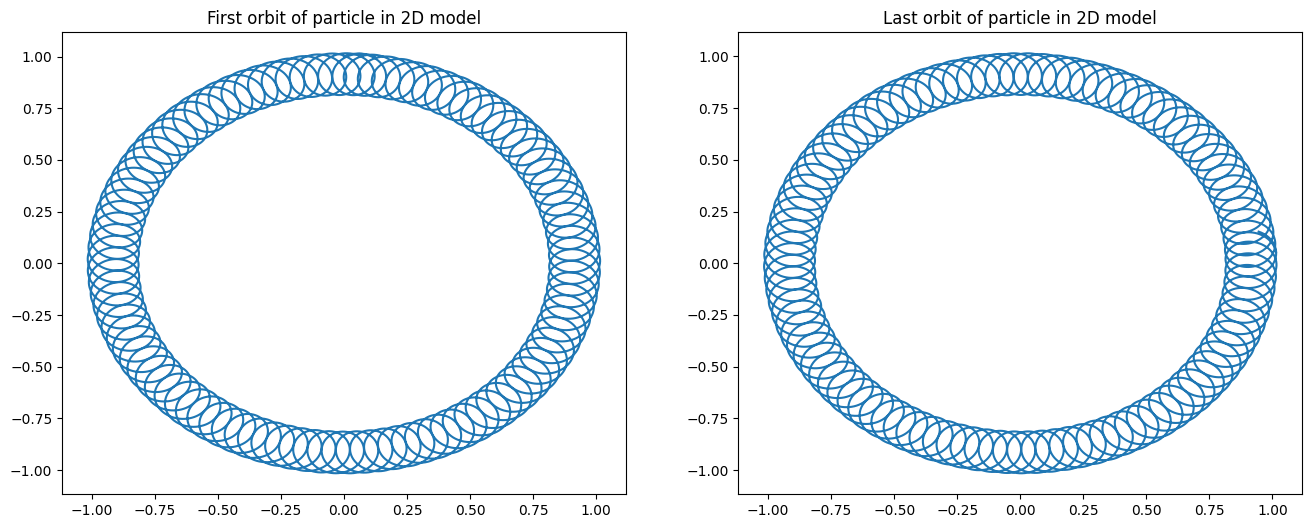

Boris: 


100%|██████████| 1000000/1000000 [00:10<00:00, 95937.92it/s]


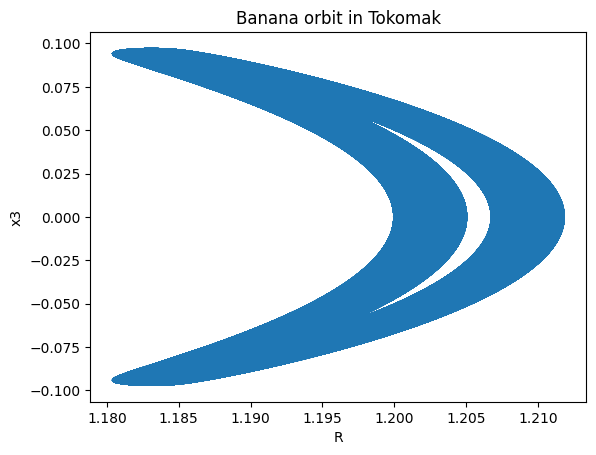

100%|██████████| 999993/999993 [01:23<00:00, 11985.89it/s]


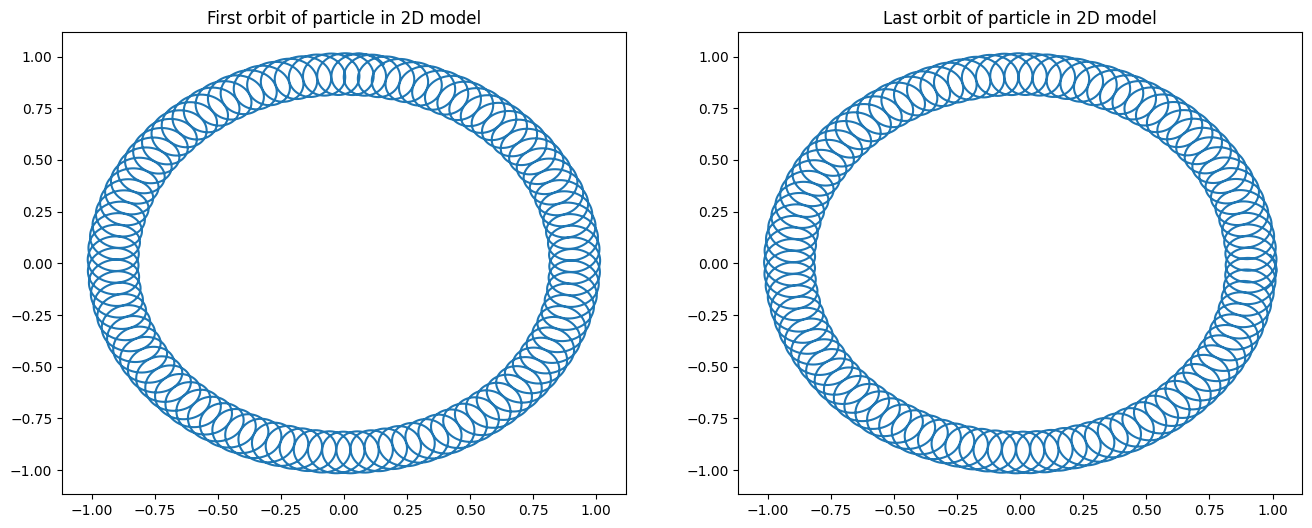

Fourth order: 


100%|██████████| 999993/999993 [01:36<00:00, 10320.57it/s]


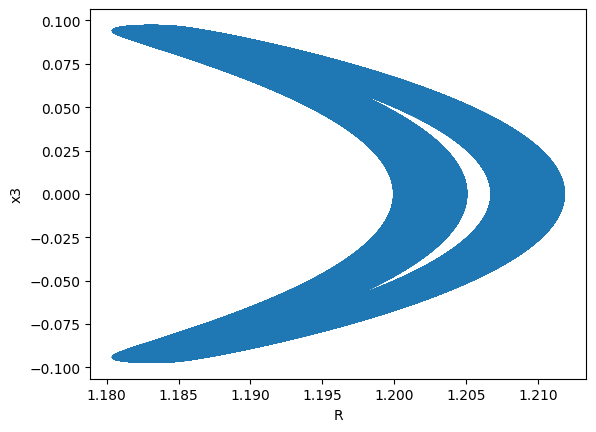

In [59]:
# ===============================================
# Run numerical integration for different solvers
# ===============================================
h      = 0.1
T_max  = 1e5
nsteps = int(T_max / h)

# 2D charged particle
orbit_time = int(2 * np.pi * 1100)
x0_2d = np.array([0.0, 1.0, 0.1])
v0_2d = np.array([0.09, 0.05, 0.20])

# Tokamak magnetic field
x0_tokamak = np.array([1.2, 0.0, 0.0])
v0_tokamak = np.array([0, 4.816e-4, -2.059e-3])

# ===== Boris =====
# 2D
v_mhalf = init_v_minus_half(x0_2d, v0_2d, B_2D, dU_2D, h)
X_vals_boris, V_vals_boris = integrate_boris(x0_2d, v_mhalf, nsteps, B_2D, dU_2D, h)

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title("First orbit of particle in 2D model")
plt.plot(X_vals_boris[:orbit_time, 0], X_vals_boris[:orbit_time, 1])
plt.subplot(1, 2, 2)
plt.title("Last orbit of particle in 2D model")
plt.plot(X_vals_boris[-orbit_time:, 0], X_vals_boris[-orbit_time:, 1])
plt.show()

# Tokamak
print("Boris: ")
v_mhalf = init_v_minus_half(x0_tokamak, v0_tokamak, B_tokamak, dU_tokamak, h)
X_vals_boris, V_vals_boris = integrate_boris(x0_tokamak, v0_tokamak, nsteps, B_tokamak, dU_tokamak, h)

R = np.sqrt(X_vals_boris[:,0]**2 + X_vals_boris[:,1]**2)
plt.figure()
plt.plot(R, X_vals_boris[:,2])
plt.title("Banana orbit in Tokomak")
plt.xlabel('R'); plt.ylabel('x3')
plt.show()

# ===== Forth-Order Symmetric Multistep =====
# 2D
X_vals_fo = integrate_fo_multi(x0_2d, v0_2d, nsteps, B_2D, dU_2D, A_2D, A_jacobian_2D, h)

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title("First orbit of particle in 2D model")
plt.plot(X_vals_fo[:orbit_time, 0], X_vals_fo[:orbit_time, 1])
plt.subplot(1, 2, 2)
plt.title("Last orbit of particle in 2D model")
plt.plot(X_vals_fo[-orbit_time:, 0], X_vals_fo[-orbit_time:, 1])
plt.show()

# Tokamak
print("Fourth order: ")
X_vals_fo = integrate_fo_multi(x0_tokamak, v0_tokamak, nsteps, B_tokamak, dU_tokamak, A_tokamak, A_jacobian_tokamak, h)

R = np.sqrt(X_vals_fo[:,0]**2 + X_vals_fo[:,1]**2)
plt.figure()
plt.plot(R, X_vals_fo[:,2])
plt.xlabel('R'); plt.ylabel('x3')
plt.show()

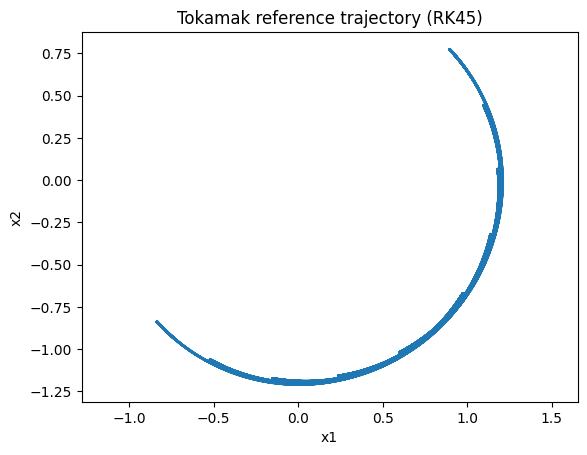

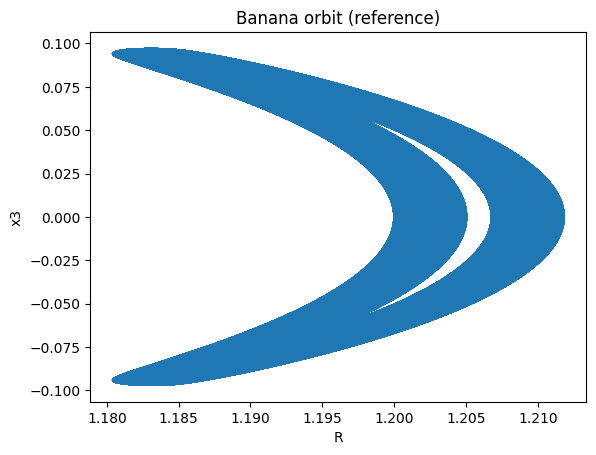

In [61]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Lorentz-force RHS: ẋ = v, v̇ = v × B(x) − ∇U(x)
def rhs(t, y):
    x = y[:3]
    v = y[3:]
    B = B_tokamak(x)
    dU = dU_tokamak(x)
    # B = B_2D(x)
    # dU = dU_2D(x)
    dxdt = v
    dvdt = np.cross(v, B) - dU
    return np.concatenate((dxdt, dvdt))

# ==========================
#  Initial conditions
# ==========================

# Tokamak
x0 = np.array([1.2, 0.0, 0.0], dtype=np.float64)
v0 = np.array([0.0, 4.816e-4, -2.059e-3], dtype=np.float64)

# 2D
# x0 = np.array([0.0, 1.0, 0.1])
# v0 = np.array([0.09, 0.05, 0.20])

y0 = np.concatenate((x0, v0))

# ==========================
#  Integration parameters
# ==========================

T_max = 1e5     # shorten from 1e5 for testing; can increase later
t_eval = np.arange(0, T_max, step=h)

sol = solve_ivp(rhs, [0, T_max], y0, method='RK45', t_eval=t_eval,
                rtol=1e-12, atol=1e-12)

# ==========================
#  Plot reference trajectory
# ==========================

X = sol.y[:3, :].T
R = np.sqrt(X[:,0]**2 + X[:,1]**2)

# plt.figure()
# plt.plot(X[:orbit_time, 0], X[:orbit_time, 1])
# plt.show()

plt.figure()
plt.plot(X[:,0], X[:,1])
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Tokamak reference trajectory (RK45)')
plt.axis('equal')
plt.show()

plt.figure()
plt.plot(R, X[:,2])
plt.xlabel('R'); plt.ylabel('x3')
plt.title('Banana orbit (reference)')
plt.show()
